In [ ]:
#Librerías para manejo de DataSet y Visulaización
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

#Librerías para abrir DataSet
from google.colab import auth
auth.authenticate_user()
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from oauth2client.client import GoogleCredentials
from IPython.display import Javascript

#Librerías para modelado y métrica
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

#Mejoras en presentación del código
import warnings
warnings.filterwarnings("ignore")
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1_HfCQoqyOAYjFaFA_hE3JhApbI6OrcfL/view?usp=sharing'

id = link.split("/")[-2] 

downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('Occupancy_Estimation.csv')  

df2 = pd.read_csv('Occupancy_Estimation.csv')

# Abstract

El objetivo de este trabajo es la predicción del número de personas en una habitación a partir de los datos de las mediciones de distintos sensores colocados dentro de la habitación. La pregunta principal que este trabajo pretende responder es: "¿Cuantas personas se encuentran en una habitación en un momento dado?" 
La metodología del trabajo consistirá en la elección de un dataset, el análisis exploratorio del mismo
El equipo de trabajo utilizará el dataset provisto por https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation para el entrenamiento y validación de los modelos utilizados para responder esta pregunta.

Este dataset contiene datos de 15 sensores distintos que recolectaron información a lo largo de 4 días, en un experimento controlado con la ocupación en la habitación variando entre 0 y 3 personas. Room_Occupancy_Coun del conteo de ocupación en la habitación se anotó manualmente.

En este experimento se utilizaron cinco tipos diferentes de sensores no intrusivos: temperatura, luz, sonido, CO2 e infrarrojo pasivo digital (PIR). Los sensores de CO2, sonido y PIR necesitaban calibración manual. El sensor de sonido es esencialmente un micrófono con un amplificador analógico. El sensor PIR tiene dos potenciómetros: uno para ajustar la sensibilidad y el otro para ajustar el tiempo durante el cual la salida permanece alta después de detectar movimiento. Los nodos sensores S1-S4 consistían en sensores de temperatura, luz y sonido, S5 tenía un sensor de CO2 y S6 y S7 tenían un sensor PIR cada uno que se desplegaron en los salientes del techo en un ángulo que maximizaba el campo de visión del sensor para el movimiento.

El dataset fue recopilado como parte de la tesis de maestría de Adarsh Pal Singh, **"Machine Learning for IoT Applications: Sensor Data Analytics and Data Reduction Techniques"**, accesible en https://web2py.iiit.ac.in/research_centres/publications/view_publication/mastersthesis/872

##Objetivo
La interrogante principal para realizar todo un análisis de estos datos, como se marco anteriormente es saber ¿Cuantas personas se encuentran en una habitación en un momento dado?. La otra pregunta que se desprende de esta es:

> ¿Que vamos a obtener con saber esa información?

Con el equipo de trabajo llegamos a la conclusión de que predecir cuantas personas pueden ocupar una habitación en un momento dado, representaría un valor económico significativo para las cadenas hoteleras,hostales, posadas y  casas de verano. Replicar la idea de este modelo implicarían que puedan tener una estimación de cual va ser su ocupación y tomar las medidas necesarias para que se mantenga o aumente dependiendo de la temporada.

A continuación observaremos los datos y crearemos hipótesis que validaremos en el análisis de los mismos

##Información de atributos:
Date: AAAA/MM/DD

Time: HH:MM:SS

Temperatura: de la habitación en grados Celsius

Luz: Nivel de luz en la habitación medidos en Lux

Sonido: En voltios (salida del amplificador leída por ADC)

CO2: análisis de dióxido de carbono medido en PPM

Pendiente de CO2: Pendiente de los valores de CO2 tomados en una ventana deslizante

PIR: valor binario que transmite la detección de movimiento

Room_Occupancy_Count: Conteo de ocumantes en la habitación. En el conteo solo se registraron (0, 1, 2, 3) personas en la habitación.

# Analisís de los datos

In [ ]:
#Información de cantidad de datos y atributos
df2.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

De esta primera observación vemos que tenemos dos atributos del tipo objeto que son **“Date”** y **“Time”** y después tenemos float e int. Hay un total 10129 de filas y 19 columnas (Atributos).

No hay valores nulos. La no existencia de estos valores en el dataset se debe a que fueron removidos por el autor que recopiló el dataset. Esto se documenta en su tesis de maestría. Saber que ya existe un procesamiento previo de los datos es importante ya que puede informar el accionar del grupo de trabajo para el proyecto de data science.

##Observación de los datos

In [ ]:
print(df2)

<IPython.core.display.Javascript object>

             Date      Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  \
0      2017/12/22  10:49:41    24.94    24.75    24.56    25.38       121   
1      2017/12/22  10:50:12    24.94    24.75    24.56    25.44       121   
2      2017/12/22  10:50:42    25.00    24.75    24.50    25.44       121   
3      2017/12/22  10:51:13    25.00    24.75    24.56    25.44       121   
4      2017/12/22  10:51:44    25.00    24.75    24.56    25.44       121   
...           ...       ...      ...      ...      ...      ...       ...   
10124  2018/01/11  08:58:07    25.06    25.13    24.69    25.31         6   
10125  2018/01/11  08:58:37    25.06    25.06    24.69    25.25         6   
10126  2018/01/11  08:59:08    25.13    25.06    24.69    25.25         6   
10127  2018/01/11  08:59:39    25.13    25.06    24.69    25.25         6   
10128  2018/01/11  09:00:09    25.13    25.06    24.69    25.25         6   

       S2_Light  S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound

### Conteo de observación de ocupantes en la habitación
Sabiendo que para esta prueba solo se registro hasta 3 personas en la habitación vamos a contar las repeticiones de cuantas filas hay sin ocupantes, cuantas con 1 solo ocupante y así hasta 3 ocupante.

In [ ]:
for i in range(4):
  print(f"Cantidad de observaciones con {i} personas en la habitación: {(df2['Room_Occupancy_Count']==i).sum()}")

<IPython.core.display.Javascript object>

Cantidad de observaciones con 0 personas en la habitación: 8228
Cantidad de observaciones con 1 personas en la habitación: 459
Cantidad de observaciones con 2 personas en la habitación: 748
Cantidad de observaciones con 3 personas en la habitación: 694


## Buscando Outliers

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Temperatura de S4_Temp (Celcius)')

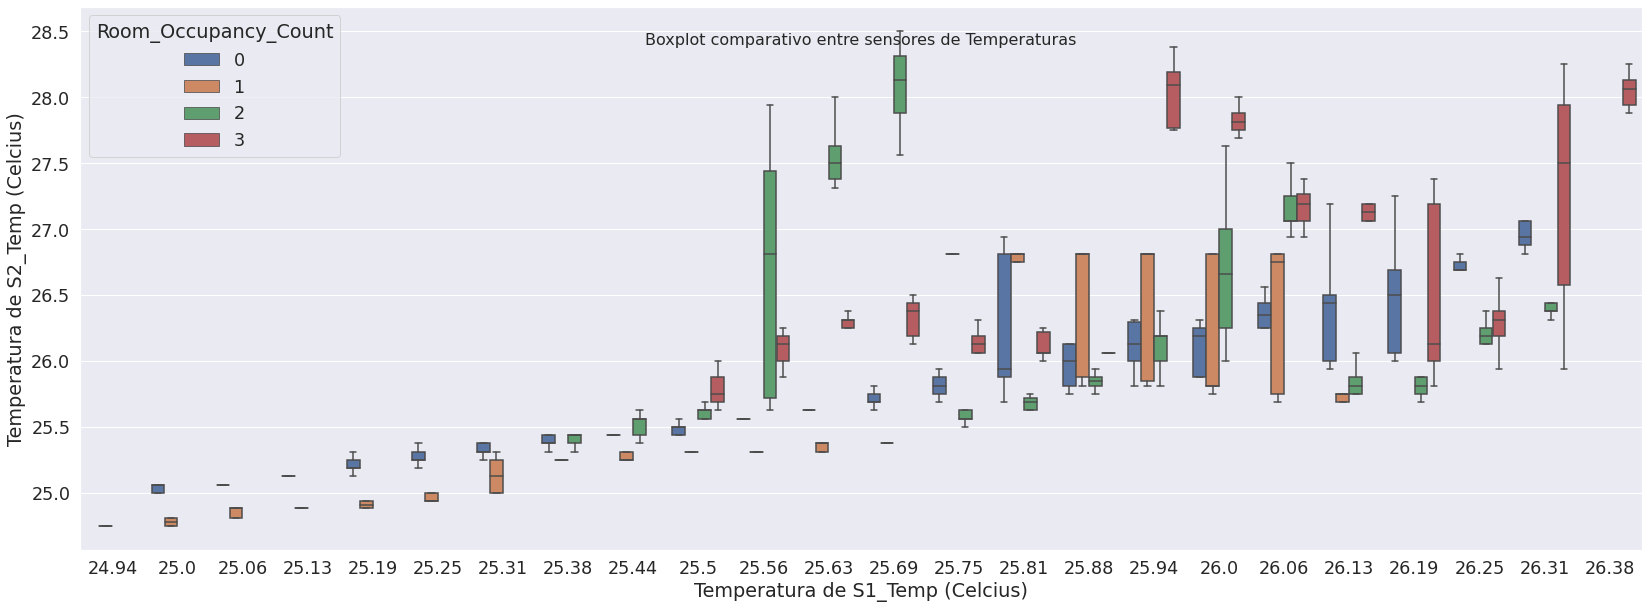

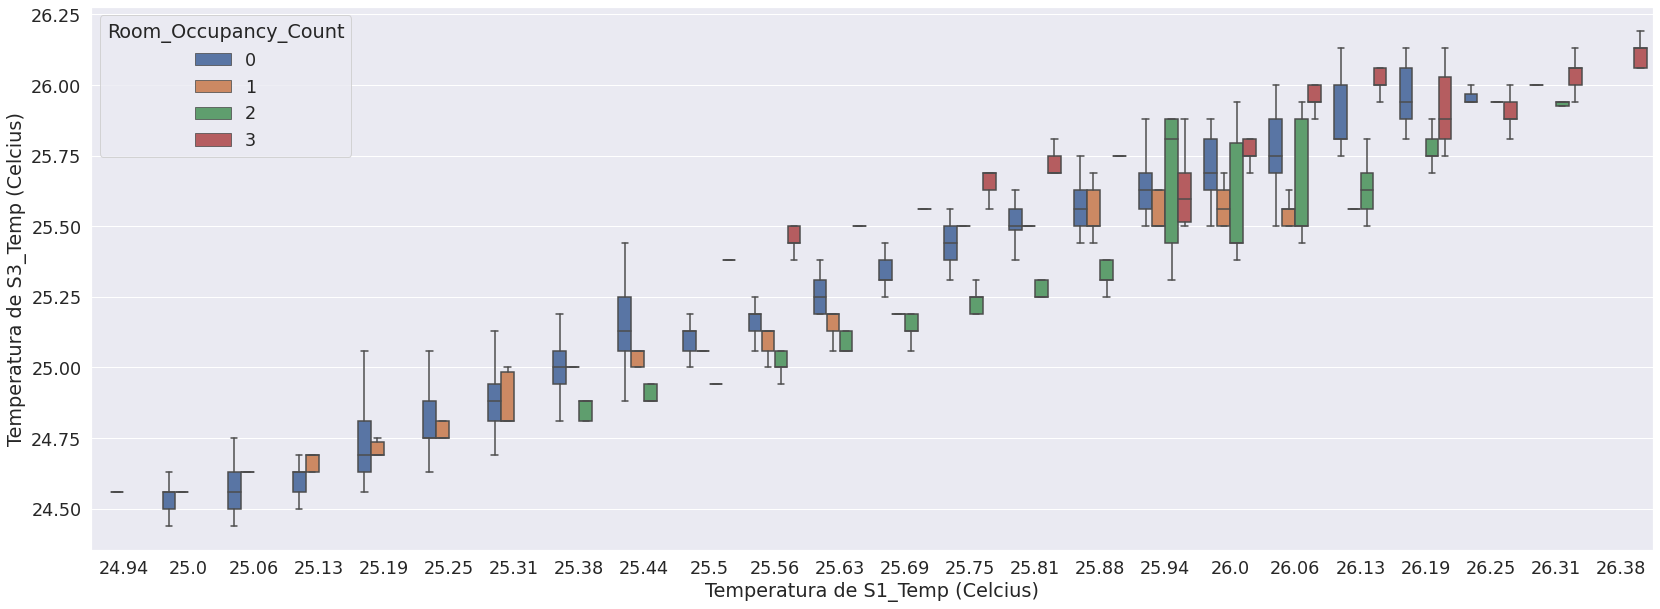

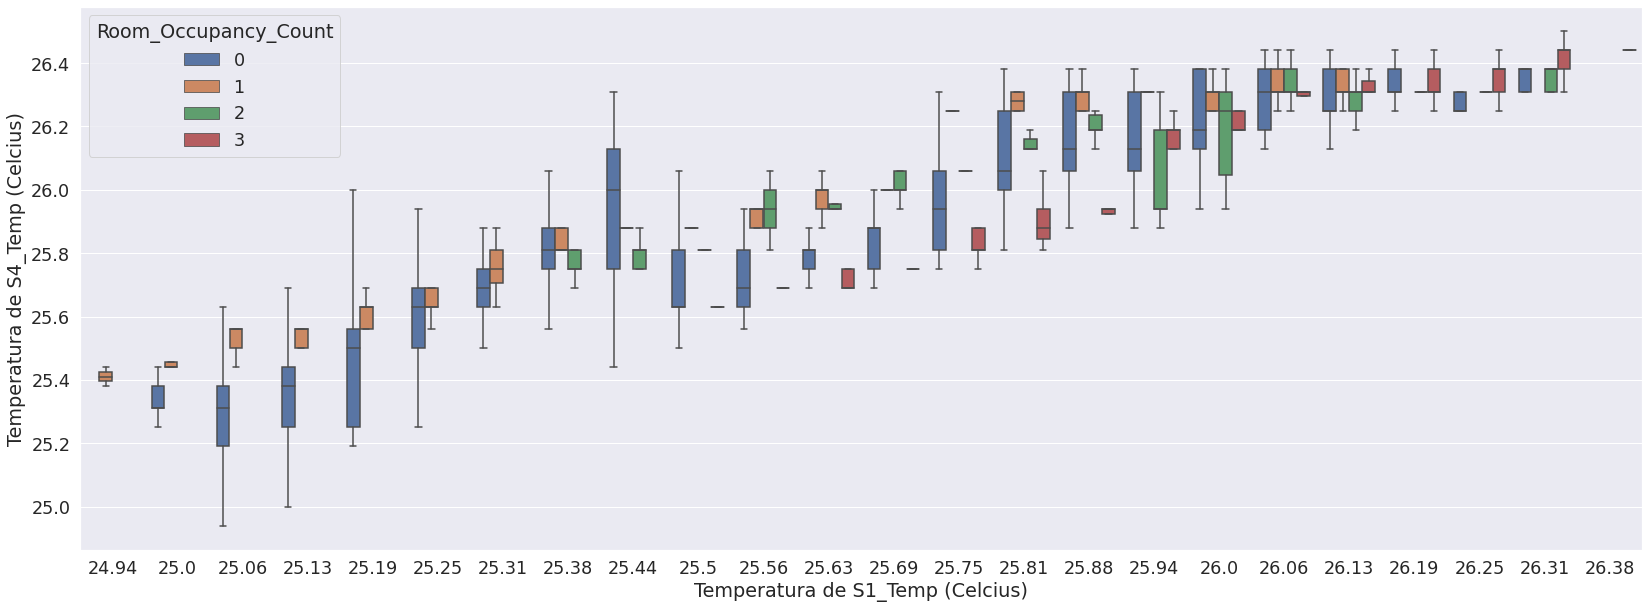

In [ ]:
plt.figure(figsize=(28,10))
sns.boxplot(x=df2.S1_Temp, y= df2.S2_Temp, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.title('Boxplot comparativo entre sensores de Temperaturas',fontsize=16, y=0.92)
plt.xlabel('Temperatura de S1_Temp (Celcius)')
plt.ylabel(f'Temperatura de S2_Temp (Celcius)')

plt.figure(figsize=(28,10))
sns.boxplot(x=df2.S1_Temp, y= df2.S3_Temp, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.xlabel('Temperatura de S1_Temp (Celcius)')
plt.ylabel(f'Temperatura de S3_Temp (Celcius)')

plt.figure(figsize=(28,10))
sns.boxplot(x=df2.S1_Temp, y= df2.S4_Temp, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.xlabel('Temperatura de S1_Temp (Celcius)')
plt.ylabel(f'Temperatura de S4_Temp (Celcius)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Sensor de Luz S4_Light (Lux)')

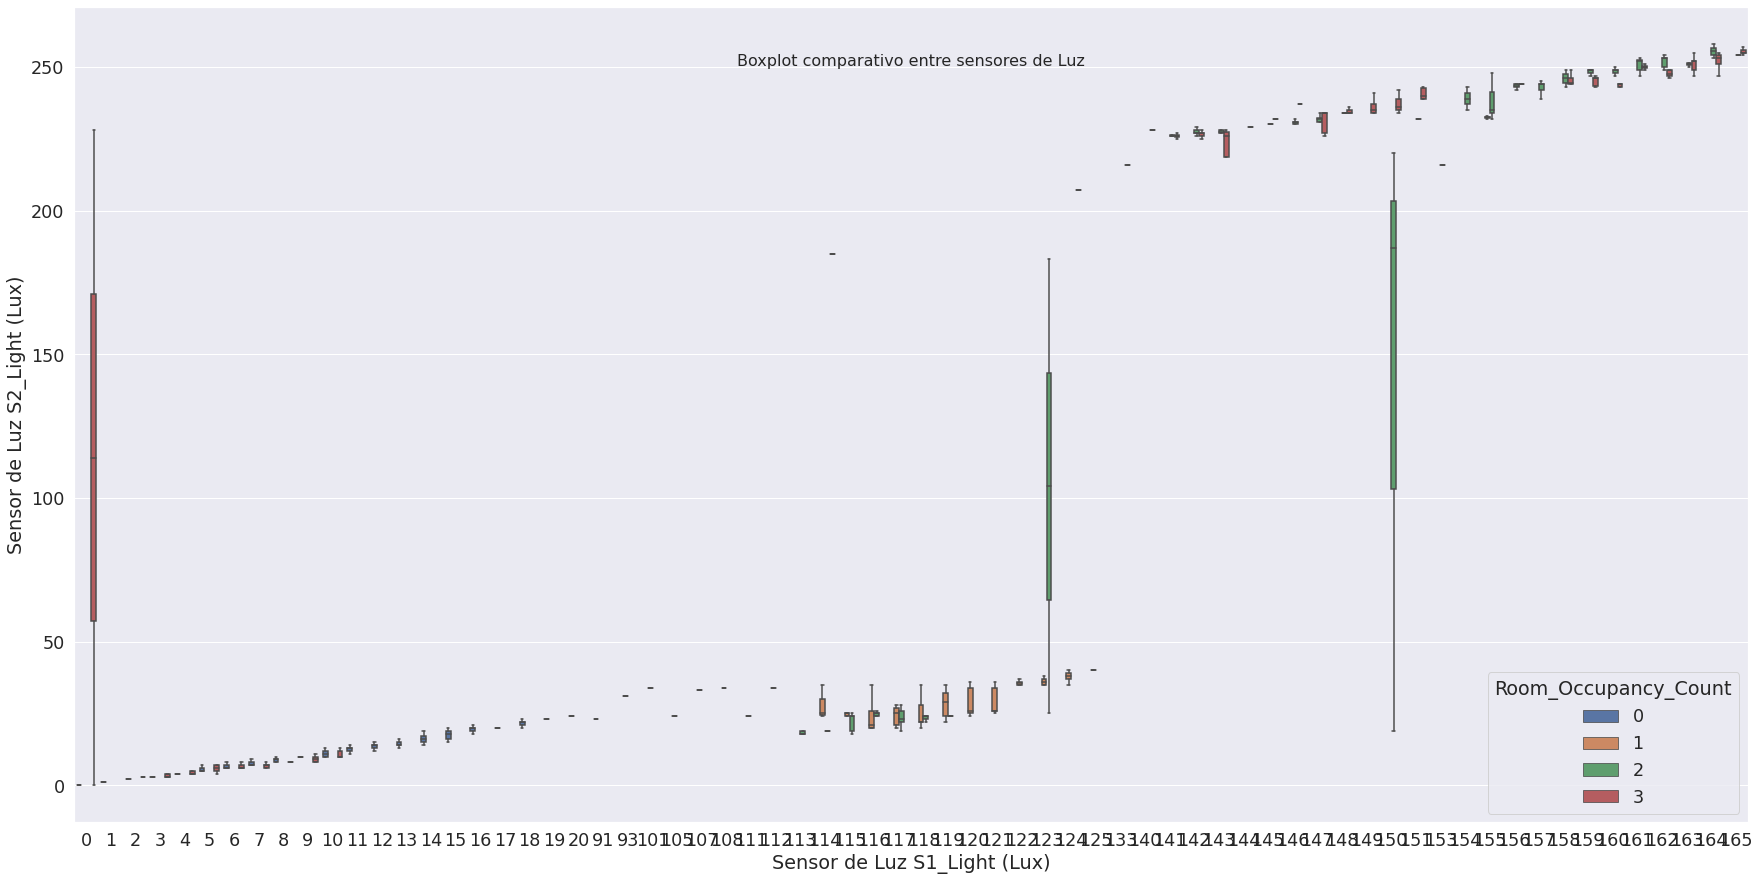

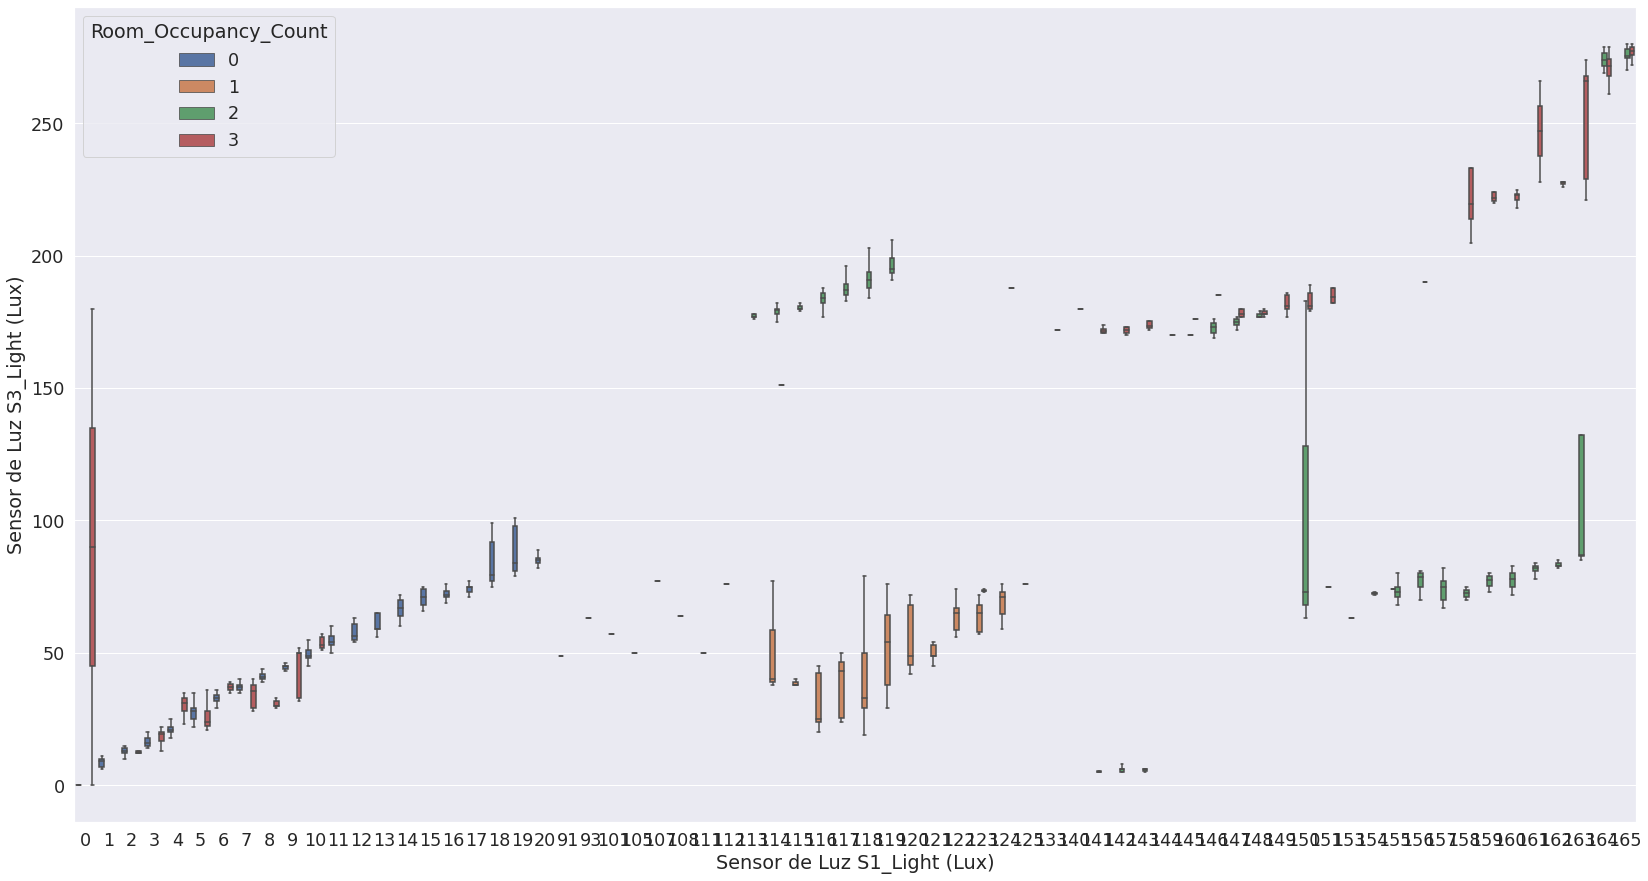

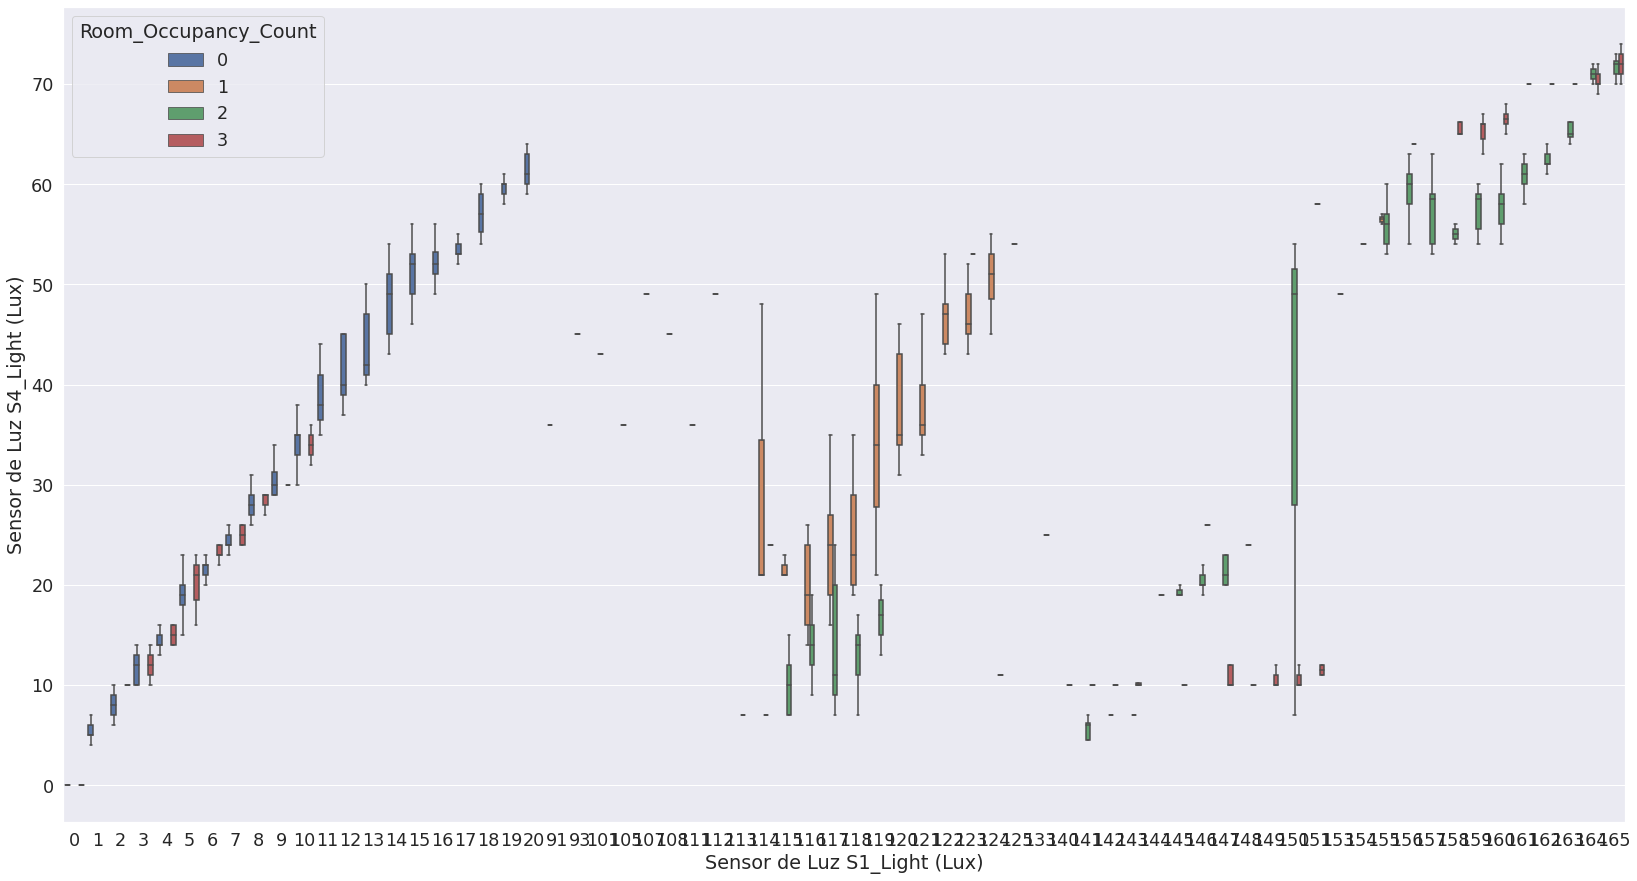

In [ ]:
plt.figure(figsize=(30,15))
sns.boxplot(x=df2.S1_Light, y= df2.S2_Light, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.title('Boxplot comparativo entre sensores de Luz',fontsize=16, y=0.92)
plt.xlabel('Sensor de Luz S1_Light (Lux)')
plt.ylabel('Sensor de Luz S2_Light (Lux)')

plt.figure(figsize=(28,15))
sns.boxplot(x=df2.S1_Light, y= df2.S3_Light, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.xlabel('Sensor de Luz S1_Light (Lux)')
plt.ylabel('Sensor de Luz S3_Light (Lux)')

plt.figure(figsize=(28,15))
sns.boxplot(x=df2.S1_Light, y= df2.S4_Light, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.xlabel('Sensor de Luz S1_Light (Lux)')
plt.ylabel('Sensor de Luz S4_Light (Lux)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Sensor S7_PIR')

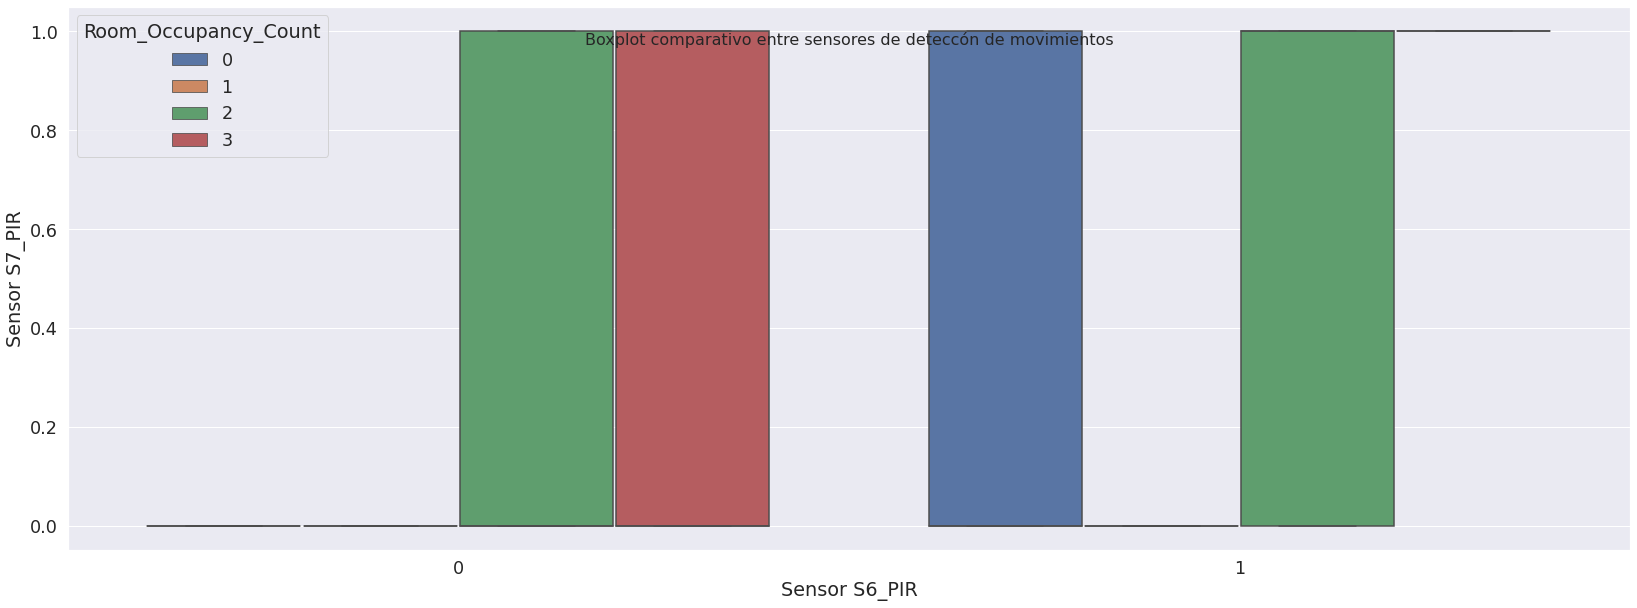

In [ ]:
plt.figure(figsize=(28,10))
sns.boxplot(x=df2.S6_PIR, y= df2.S7_PIR, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.title('Boxplot comparativo entre sensores de deteccón de movimientos',fontsize=16, y=0.92)
plt.xlabel('Sensor S6_PIR')
plt.ylabel('Sensor S7_PIR')



Los resultados obtenidos después de comparar cada sensor del mismo tipo es que este conjunto de datos no presenta **outliers** Lo cual es esperado dado que ya fueron pe-procesados. También se puede obtener la siguiente apreciación.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Luz (Lux)')

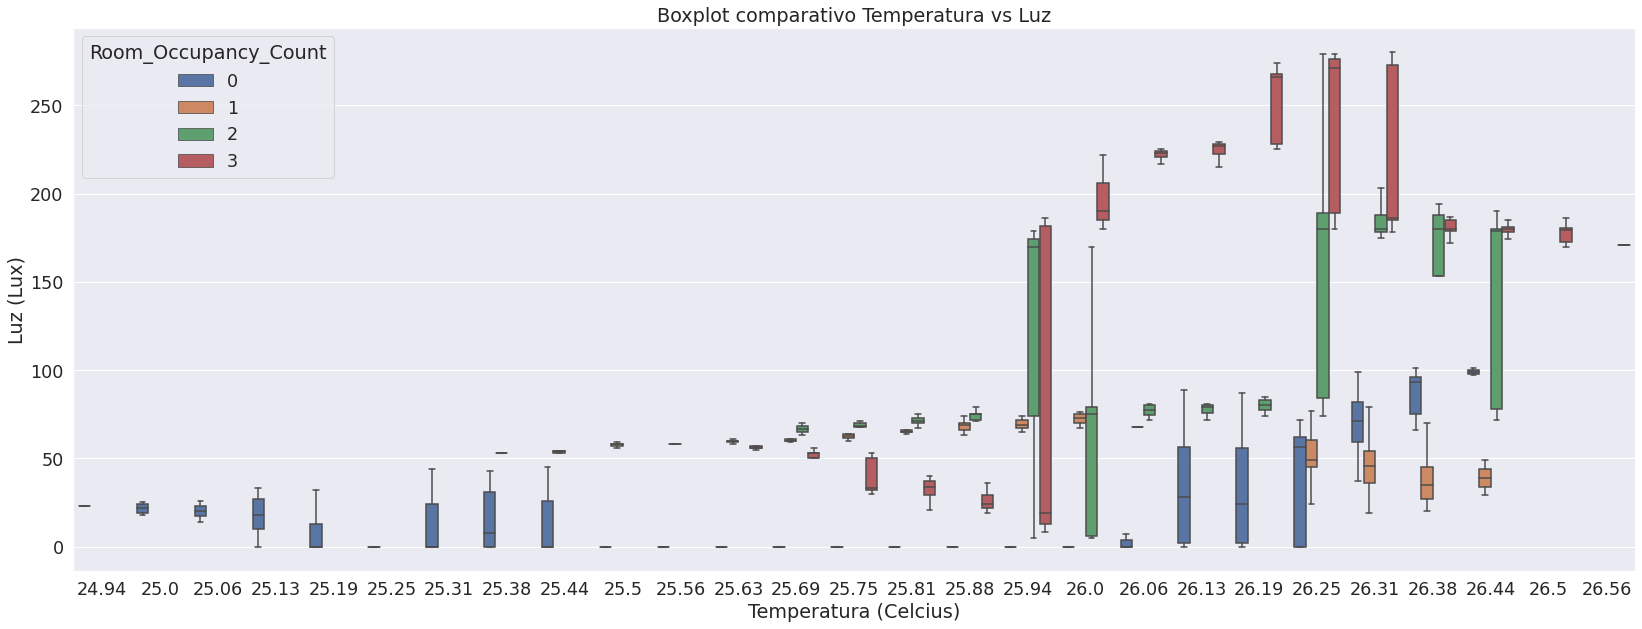

In [ ]:
plt.figure(figsize=(28,10))
sns.boxplot(x=df2.S4_Temp, y= df2.S3_Light, hue=df2.Room_Occupancy_Count,showfliers=False)
plt.title('Boxplot comparativo Temperatura vs Luz')
plt.xlabel('Temperatura (Celcius)')
plt.ylabel('Luz (Lux)')

Utilizando boxplots se puede verificar las observaciones de rangos de temperatura y luz:

1.   una medición de temperatura de entre 26 y 26,5 grados y de luz de entre 150 y 250 Lux, es altamente probable que haya 2 o 3 personas en la habitación. 
2.   Y que entre los 24.95 y 25.63 grados y 0 y 50 Lux de iluminación no hay ocupantes den la habitación.

##Analizando otras Graficas 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

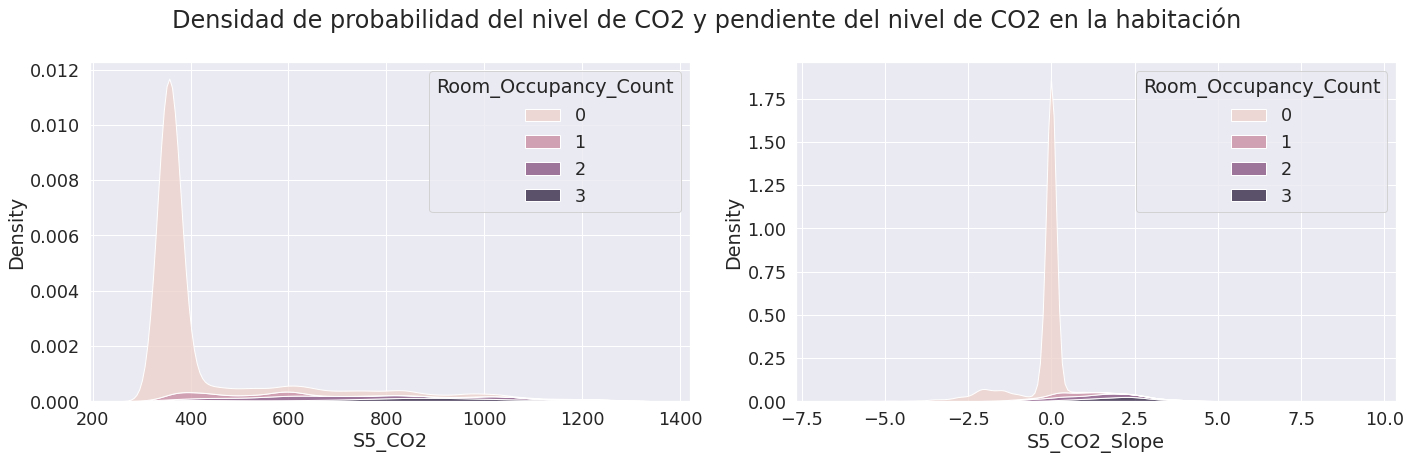

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw=dict(width_ratios=[1, 1]))
f.suptitle('Densidad de probabilidad del nivel de CO2 y pendiente del nivel de CO2 en la habitación', fontsize=24, y=1.08)
sns.kdeplot(data=df2, x="S5_CO2", hue="Room_Occupancy_Count", multiple="stack", ax=axs[0])
sns.kdeplot(data=df2, x="S5_CO2_Slope", hue="Room_Occupancy_Count", multiple="stack", ax=axs[1])
f.tight_layout()

Las figuras muestran una gráfica de densidad de probabilidad del nivel de CO2 en la habitación y la pendiente del nivel de CO2 en la habitación para las distintas cantidades de ocupantes. Estas graficas no resultan muy útiles para determinar la cantidad de ocupantes, pero si para determinar rangos de CO2 donde la habitación esta vacía con muy alta probabilidad.

Es interesante destacar las conclusiones que pueden obtenerse observando la segunda gráfica. El pico densidad de probabilidad para una pendiente de CO2 de 0 nos da la intuición de que si el nivel de CO2 de la habitación se mantiene constante, es porque la habitación esta vacía. A la izquierda se ve una pequeña subida, que puede interpretarse como que si el nivel de CO2 de una habitación disminuye, es probable que la misma este vacía (presuntamente, porque al retirarse los ocupantes estos dejand de emitir CO2 dentro de la habitación). Finalmente, a la derecha puede observarse que si la cantidad de CO2 aumenta, es una conclusión razonable que entró gente a la habitación.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

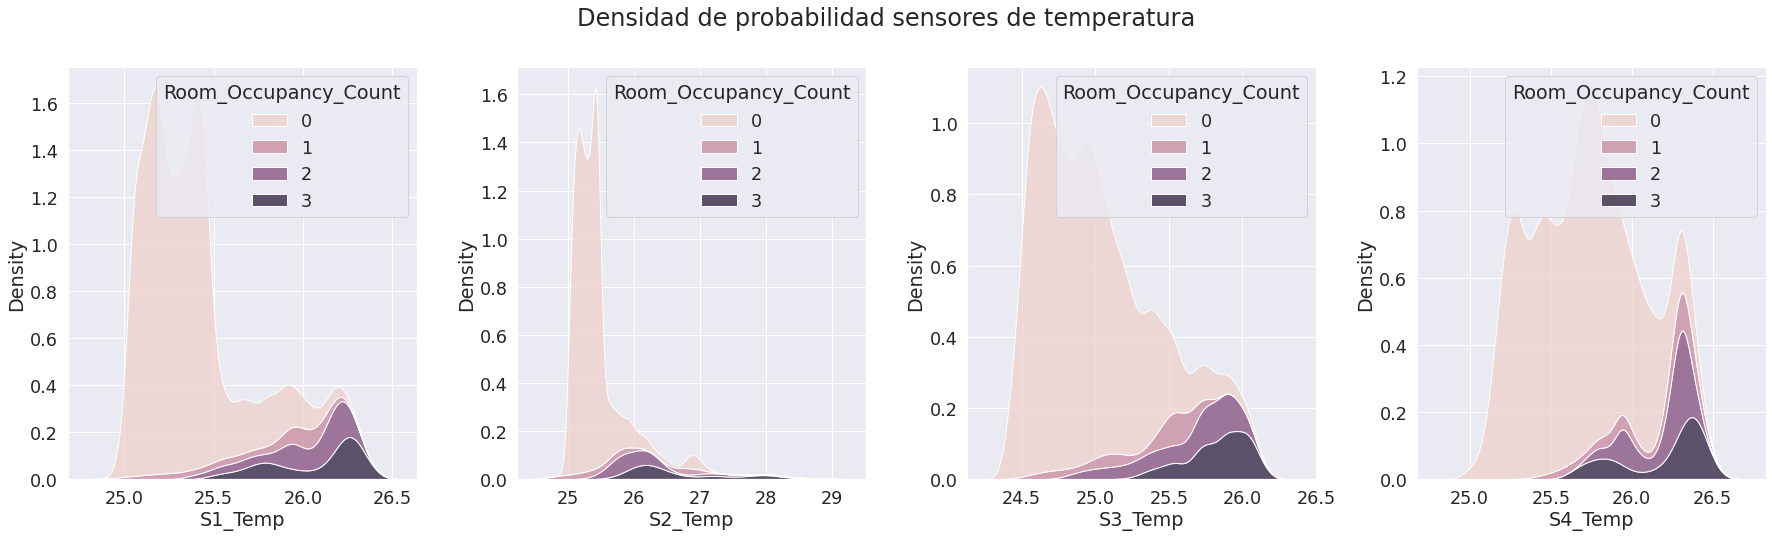

In [ ]:
f, axs = plt.subplots(1, 4, figsize=(25, 7), gridspec_kw=dict(width_ratios=[1, 1, 1, 1]))
f.suptitle('Densidad de probabilidad sensores de temperatura', fontsize=24, y=1.08)
sns.kdeplot(data=df2, x="S1_Temp", hue="Room_Occupancy_Count", multiple="stack", ax=axs[0])
sns.kdeplot(data=df2, x="S2_Temp", hue="Room_Occupancy_Count", multiple="stack", ax=axs[1])
sns.kdeplot(data=df2, x="S3_Temp", hue="Room_Occupancy_Count", multiple="stack", ax=axs[2])
sns.kdeplot(data=df2, x="S4_Temp", hue="Room_Occupancy_Count", multiple="stack", ax=axs[3])
f.tight_layout()

Podemos repetir la técnica anterior para obtener graficas de densidad de probabilidad de cantidad de ocupantes de acuerdo a la temperatura registrada por los distintos sensores de temperatura de la habitación.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

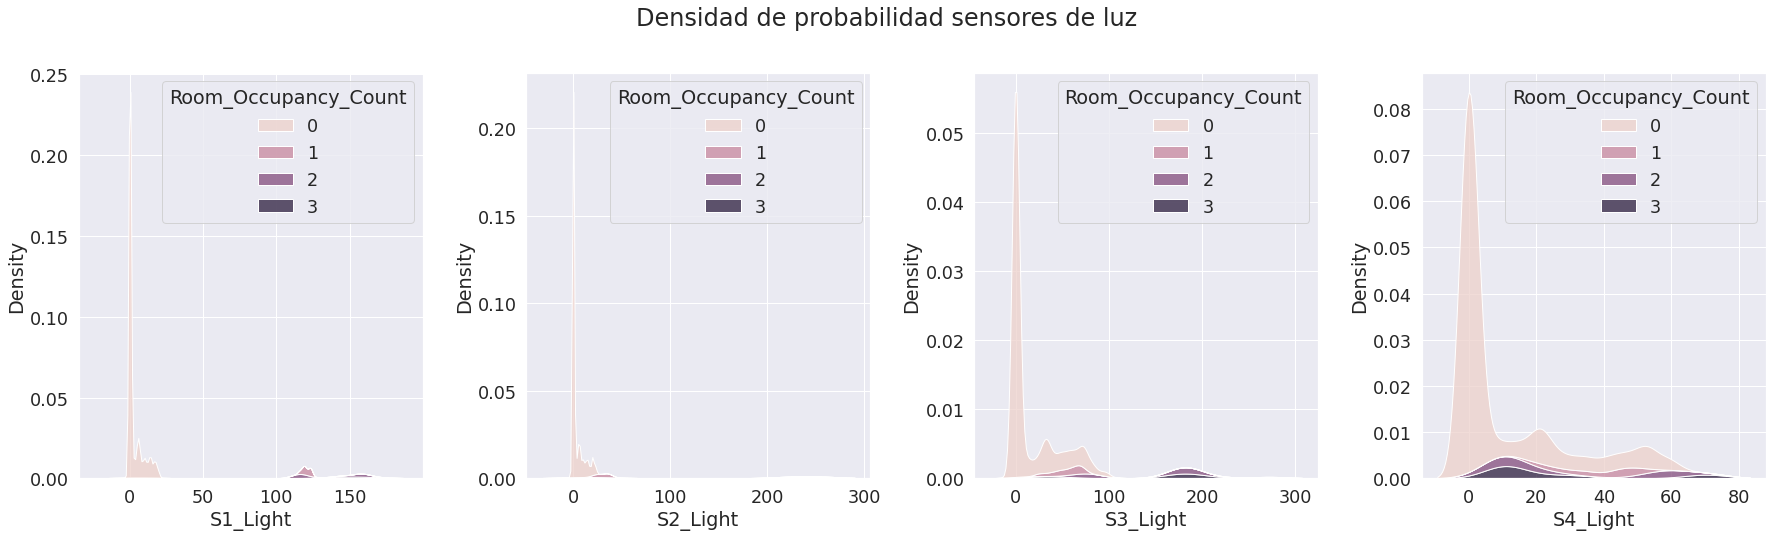

In [ ]:
f, axs = plt.subplots(1, 4, figsize=(25, 7), gridspec_kw=dict(width_ratios=[1, 1, 1, 1]))
f.suptitle('Densidad de probabilidad sensores de luz', fontsize=24, y=1.08)
sns.kdeplot(data=df2, x="S1_Light", hue="Room_Occupancy_Count", multiple="stack", ax=axs[0])
sns.kdeplot(data=df2, x="S2_Light", hue="Room_Occupancy_Count", multiple="stack", ax=axs[1])
sns.kdeplot(data=df2, x="S3_Light", hue="Room_Occupancy_Count", multiple="stack", ax=axs[2])
sns.kdeplot(data=df2, x="S4_Light", hue="Room_Occupancy_Count", multiple="stack", ax=axs[3])
f.tight_layout()

Repitiendo esta técnica pero utilizando los sensores de luz esta vez, obtenemos resultados que no son tan claros de interpretar. Esto es en gran parte por el gran rango de mediciones de los sensores de luz, que provocan muy bajos valores de densidad de probabilidad para 1, 2 y 3 personas en la habitación. Además, la última conclusión que podemos extraer de las gráficas de densidad de probabilidad, es que la mayoría de las mediciones del dataset son de cuartos vacios. Esto explica la diferencia entre las areas bajo la curva para 0 integrantes en la habitación, y 1, 2, y 3 integrantes. Esta hipótesis puede ser facilmente verificada imprimiendo las cantidades de estos valores en el dataset.

Para solucionar las limitaciones de graficar la densidad de probabilidad de acuerdo a las mediciones de luz, debemos recurrir a otra técnica de graficado para poder obtener datos más útiles.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

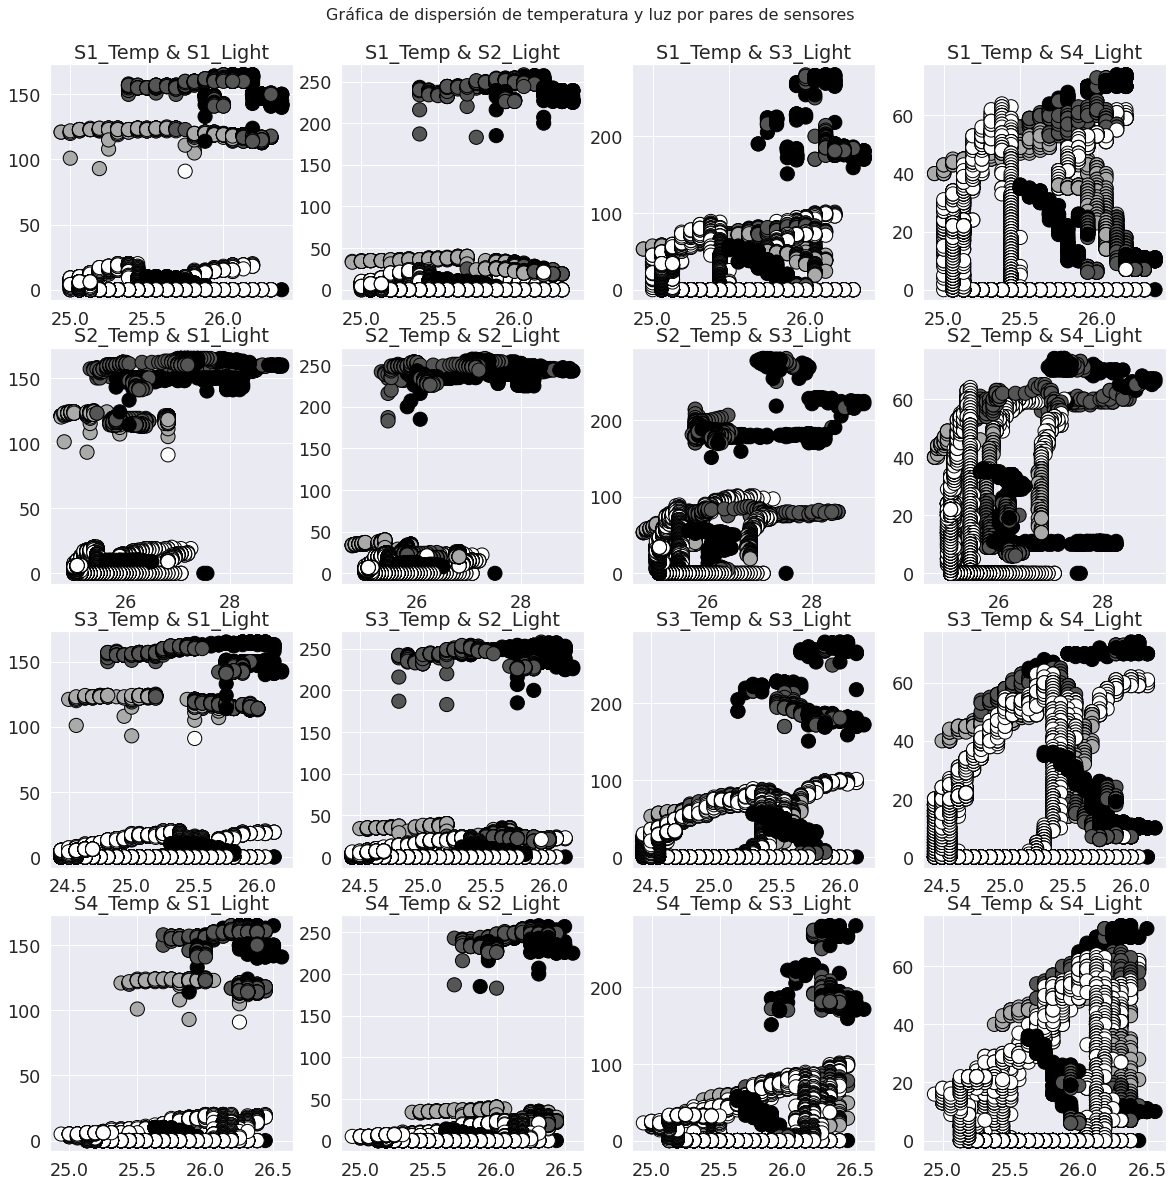

In [ ]:
import itertools
temp_sensors = ["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp"]
light_sensors = ["S1_Light", "S2_Light", "S3_Light", "S4_Light"]
combinations = [elem for elem in itertools.product(temp_sensors, light_sensors, ["Room_Occupancy_Count"])]
labels = [elem for elem in itertools.product(temp_sensors,light_sensors)]
indexes = [elem for elem in itertools.product([0,1,2,3],[0,1,2,3])]

f, axs = plt.subplots(4,4, figsize=(20, 20))
f.suptitle('Gráfica de dispersión de temperatura y luz por pares de sensores', fontsize=16, y=0.92)

for index,label,combination in zip(indexes,labels,combinations):
  sub_dataframe = df2[[combination[0], combination[1], combination[2]]]
  vals = sub_dataframe.values
  axs[index[0], index[1]].scatter(vals[:, 0], vals[:, 1], c=vals[:, 2], cmap=plt.cm.gray_r, s=200, edgecolor='black')
  axs[index[0], index[1]].set_title(f"{label[0]} & {label[1]}", loc='center', fontsize='medium')

La grilla de graficos muestra mediciones de temperatura en el eje X y mediciones de luz en el eje Y. Los puntos de las gráficas se oscurecen para mediciones con más personas en la habitación. Con estas gráficas es posible diferenciar cúmulos de puntos donde se agrupan mediciones para 2 y 3 personas en la habitación, cosa que en las gráficas de densidad de CO2 no era posible. Por ejemplo, se nota que para el sensor de temperatura 4 y el sensor de luz 3, al obtener una medición de temperatura de entre 26 y 26,5 grados y de luz de entre 150 y 250 Lux, es altamente probable que haya 2 o 3 personas en la habitación.

A pesar de que estas gráficas estan basadas en grán parte en las mediciones de luz, podemos ver como cambiando la técnica de graficado podemos obtener mejor información de los mismos datos.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

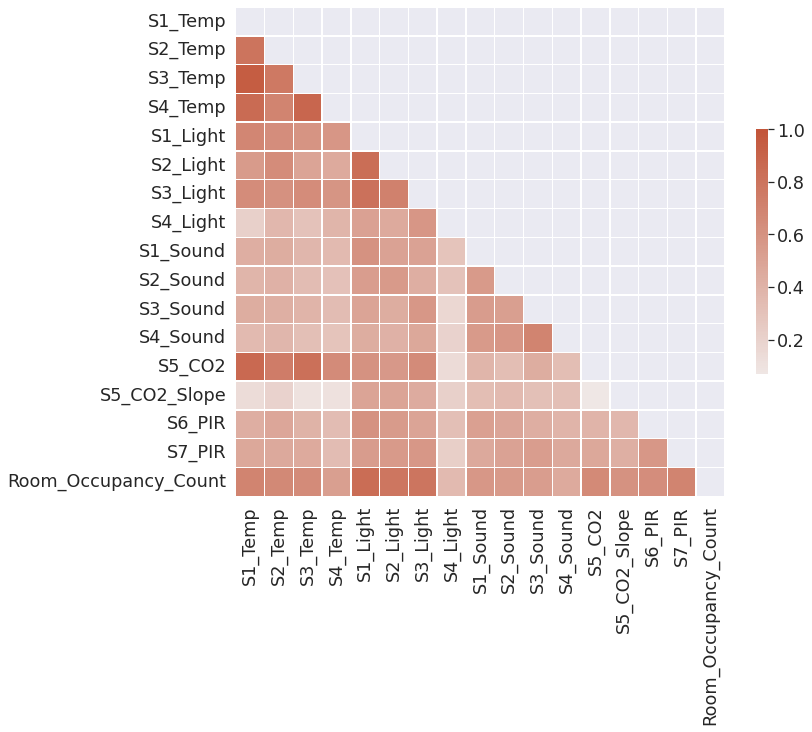

In [ ]:
corr_df = df2.drop(['Room_Occupancy_Count'], axis=1)
corr = df2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Por último, se presenta un heatmap de la matriz de correlación incluyendo la variable objetivo (Room_Occupancy_Count). Puede verse como los sensores del mismo tipo (luz, temperatura y sonido) estan altamente correlacionados entre sí. Además, se puede ver una alta correlación entre la tempreatura y la concentración de CO2 en el ambiente. Es importante notar que esta correlación no se mantiene también para la pendiente de CO2.

Resulta llamativa además, la baja correlación entre los datos del sensor S4_Light y otras variables que no corresponden a sensores de luz, dado en que este dataset hay en general una correlación media - alta entre los pares de variables.

En base a lo observado en matriz, comparamos S5_CO2 contra los distintos sensores de Temperatura y los sensores de luz contra los de temperatura.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre S5_CO2 y sensores de Temperaturas
 


Text(0.5, 1.0, 'S5_CO2 y S4_Temp')

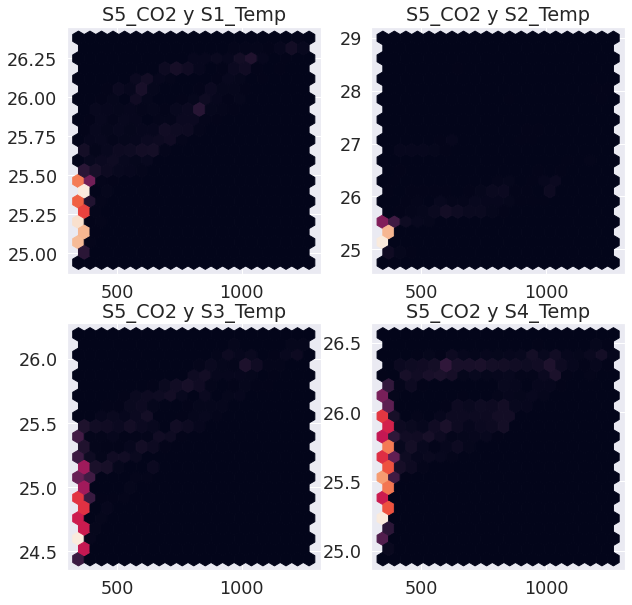

In [ ]:
x = df2["S5_CO2"]
y = df2["S1_Temp"]
y2 = df2["S2_Temp"]
y3 = df2["S3_Temp"]
y4 = df2["S4_Temp"]
print("Relación entre S5_CO2 y sensores de Temperaturas")
print(" ")
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S5_CO2 y S1_Temp")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S5_CO2 y S2_Temp")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("S5_CO2 y S3_Temp")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S5_CO2 y S4_Temp")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre S1_Light y sensores de temperatura
 


Text(0.5, 1.0, 'S1_Light y S4_Temp')

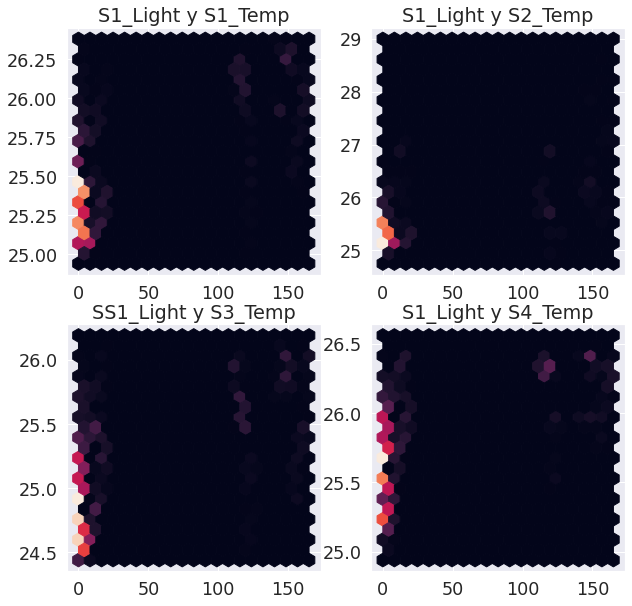

In [ ]:
print("Relación entre S1_Light y sensores de temperatura")
print(" ")
x = df2["S1_Light"]
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S1_Light y S1_Temp")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S1_Light y S2_Temp")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("SS1_Light y S3_Temp")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S1_Light y S4_Temp")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre S2_Light y sensores de temperatura
 


Text(0.5, 1.0, 'S2_Light y S4_Temp')

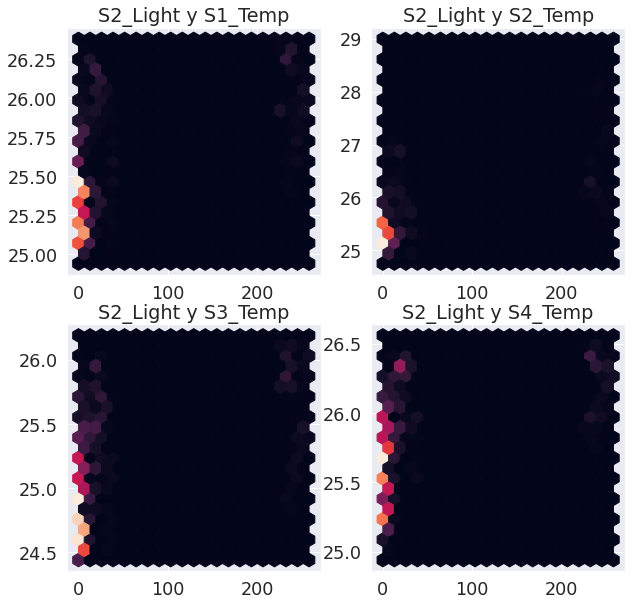

In [ ]:
print("Relación entre S2_Light y sensores de temperatura")
print(" ")
x = df2["S2_Light"]
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S2_Light y S1_Temp")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S2_Light y S2_Temp")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("S2_Light y S3_Temp")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S2_Light y S4_Temp")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre S3_Light y sensores de temperatura
 


Text(0.5, 1.0, 'S3_Light y S4_Temp')

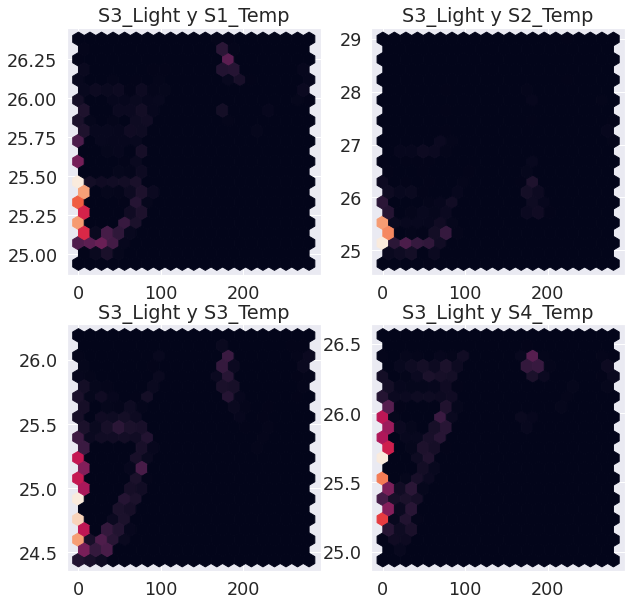

In [ ]:
print("Relación entre S3_Light y sensores de temperatura")
print(" ")
x = df2["S3_Light"]
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S3_Light y S1_Temp")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S3_Light y S2_Temp")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("S3_Light y S3_Temp")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S3_Light y S4_Temp")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre S4_Light y sensores de temperatura
 


Text(0.5, 1.0, 'S4_Light y S4_Temp')

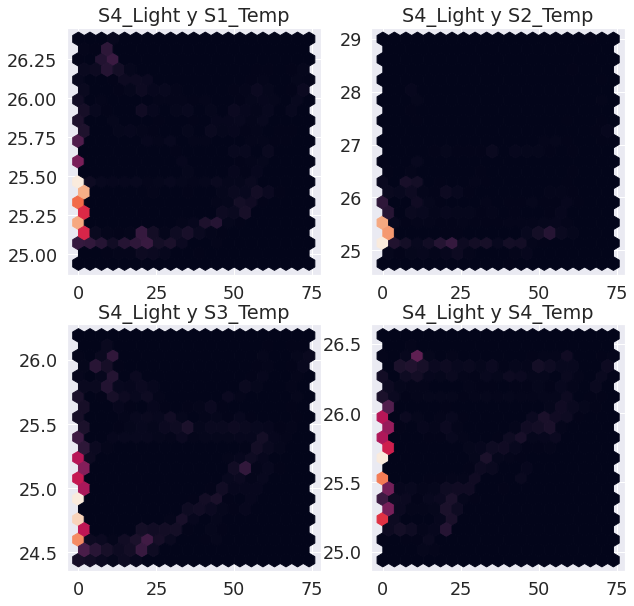

In [ ]:
print("Relación entre S4_Light y sensores de temperatura")
print(" ")
x = df2["S4_Light"]
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S4_Light y S1_Temp")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S4_Light y S2_Temp")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("S4_Light y S3_Temp")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S4_Light y S4_Temp")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre Room_Occupancy_Count y sensores de temperatura
 


Text(0.5, 1.0, 'S4_Light y S4_Temp')

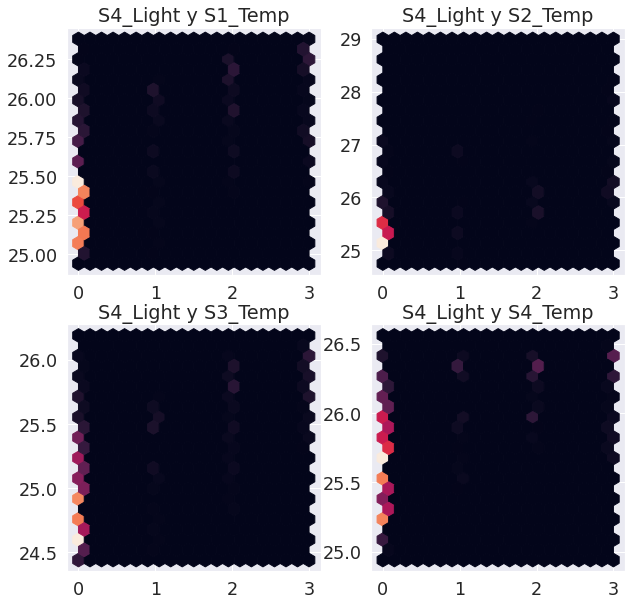

In [ ]:
print("Relación entre Room_Occupancy_Count y sensores de temperatura")
print(" ")
x = df2["Room_Occupancy_Count"]
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S4_Light y S1_Temp")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S4_Light y S2_Temp")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("S4_Light y S3_Temp")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S4_Light y S4_Temp")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Relación entre Room_Occupancy_Count y sensores de Luz
 


Text(0.5, 1.0, 'S4_Light')

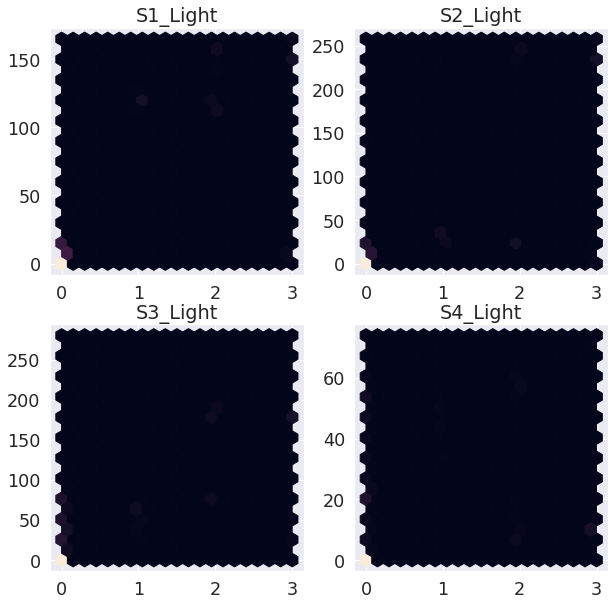

In [ ]:
print("Relación entre Room_Occupancy_Count y sensores de Luz")
print(" ")

x = df2["Room_Occupancy_Count"]
y = df2["S1_Light"]
y2 = df2["S2_Light"]
y3 = df2["S3_Light"]
y4 = df2["S4_Light"]

fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0,0].hexbin(x,y,gridsize=20)
axs[0,0].set_title("S1_Light")
axs[0,1].hexbin(x,y2,gridsize=20)
axs[0,1].set_title("S2_Light")
axs[1,0].hexbin(x,y3,gridsize=20)
axs[1,0].set_title("S3_Light")
axs[1,1].hexbin(x,y4,gridsize=20)
axs[1,1].set_title("S4_Light")

#Selección de Algorítmo

Para decidir el algoritmo a utilizar, primero debemos definir si estamos frente a un problema de regresión o clasificación. Dadas las características de problema; predicción del número de personas de una habitación en base a las mediciones de distintos sensores, estamos frente a un problema de aprendizaje supervisado de clasificación. El problema es de aprendizaje supervisado, ya que nuestros datos de entrenamiento estan correctamente etiquetados de antemano, y el problema es de clasificación ya que tenemos 4 clases en donde clasificar nuestros datos: 0, 1, 2, y 3 personas en la habitación. Sin tener más datos, ni cambiando el tipo de datos recolectados es imposible determinar si hay un número mayor a 3 personas en la habitación.

##Borrando variables categoricas
Para el procesamiento de los datos de entrada se removió la fecha y hora de la medición. Si bien se consideró convertir la hora a segundos, ya que la hora en que se toma la medición puede ser relevante para que haya o no personas en la habitación, se decidió descartarla por tener un rango mucho más amplio a las demás features. La fecha podría convertirse a categorías, pero al haber mediciones solo para 4 días, no sería útil para la predicción si se tomara una medición de la habitación en una fecha arbitraria.

In [ ]:
X = df2.drop(["Date","Time","Room_Occupancy_Count"],1)
y = df2["Room_Occupancy_Count"]
print("Nuestro vector de Features")
print(X.head())
print(" ")
print("Nuestro vector target")
print(y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Nuestro vector de Features
   S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  S4_Light  \
0    24.94    24.75    24.56    25.38       121        34        53        40   
1    24.94    24.75    24.56    25.44       121        33        53        40   
2    25.00    24.75    24.50    25.44       121        34        53        40   
3    25.00    24.75    24.56    25.44       121        34        53        40   
4    25.00    24.75    24.56    25.44       121        34        54        40   

   S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  S6_PIR  \
0      0.08      0.19      0.06      0.06     390      0.769231       0   
1      0.93      0.05      0.06      0.06     390      0.646154       0   
2      0.43      0.11      0.08      0.06     390      0.519231       0   
3      0.41      0.10      0.10      0.09     390      0.388462       0   
4      0.18      0.06      0.06      0.06     390      0.253846       0   

   S7_PIR  
0       0  
1       0  

In [ ]:
X.info()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   S1_Temp       10129 non-null  float64
 1   S2_Temp       10129 non-null  float64
 2   S3_Temp       10129 non-null  float64
 3   S4_Temp       10129 non-null  float64
 4   S1_Light      10129 non-null  int64  
 5   S2_Light      10129 non-null  int64  
 6   S3_Light      10129 non-null  int64  
 7   S4_Light      10129 non-null  int64  
 8   S1_Sound      10129 non-null  float64
 9   S2_Sound      10129 non-null  float64
 10  S3_Sound      10129 non-null  float64
 11  S4_Sound      10129 non-null  float64
 12  S5_CO2        10129 non-null  int64  
 13  S5_CO2_Slope  10129 non-null  float64
 14  S6_PIR        10129 non-null  int64  
 15  S7_PIR        10129 non-null  int64  
dtypes: float64(9), int64(7)
memory usage: 1.2 MB


# Backward_elimination
Implementaremos **Backward_elimination** para la determinar las variables más relevantes a implementar en el modelo. Aunque al analizar la cantidad de variables que disponemos actualmente, creemos que no se eliminara ninguna.

In [ ]:
def backward_elimination(data, target,significance_level = 0.05):
  features = data.columns.tolist()
  while(len(features)>0):
    features_with_constant = sm.add_constant(data[features])
    p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
    max_p_value = p_values.max()
    if(max_p_value >= significance_level):
      excluded_feature = p_values.idxmax()
      features.remove(excluded_feature)
    else:
      break 
  return features

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
features = backward_elimination(X, y)
features

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['S1_Temp',
 'S2_Temp',
 'S3_Temp',
 'S4_Temp',
 'S1_Light',
 'S2_Light',
 'S3_Light',
 'S4_Light',
 'S1_Sound',
 'S2_Sound',
 'S3_Sound',
 'S4_Sound',
 'S5_CO2_Slope',
 'S6_PIR',
 'S7_PIR']

Después de ejecutar **Backward_elimination**, solo elimino un atributo, **S5_CO2** lo cual tiene sentido al no disponer de una cantidad superior. Así, que se decidió implementar el modelo de *tree.DecisionTreeClassifier* para compararlo con lo ejecutado en la presentación anterior. Suponemos que los resultados serán similares.

In [ ]:
X  = X.drop("S5_CO2",1)
print(X)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

       S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  \
0        24.94    24.75    24.56    25.38       121        34        53   
1        24.94    24.75    24.56    25.44       121        33        53   
2        25.00    24.75    24.50    25.44       121        34        53   
3        25.00    24.75    24.56    25.44       121        34        53   
4        25.00    24.75    24.56    25.44       121        34        54   
...        ...      ...      ...      ...       ...       ...       ...   
10124    25.06    25.13    24.69    25.31         6         7        33   
10125    25.06    25.06    24.69    25.25         6         7        34   
10126    25.13    25.06    24.69    25.25         6         7        34   
10127    25.13    25.06    24.69    25.25         6         7        34   
10128    25.13    25.06    24.69    25.25         6         7        34   

       S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2_Slope  S6_PIR  \
0            40   

#Creando Modelo


In [ ]:
#Separacion en train / test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Declaración de funciones para la etapa de análisis

def plot_confusion_matrix(conf_matrix):

  df_cm = pd.DataFrame(conf_matrix, range(conf_matrix.shape[0]), range(conf_matrix.shape[1]))
  sns.set(font_scale=1.6)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
  plt.suptitle('Matriz de Confusión')

  plt.show()

def multiclass_matrix_to_binary(conf_matrix, class_idx):
  mat_size = conf_matrix.shape[0]
  #i es predicted y j es true
  tp = conf_matrix[class_idx,class_idx] #true positives
  tn = 0
  for i in range(mat_size): #true negatives
    for j in range(mat_size):
      tn += conf_matrix[i,j] if (i != class_idx and j != class_idx) else 0
  fp = sum([conf_matrix[class_idx,i] for i in range(mat_size) if i != class_idx]) #false positives
  fn = sum([conf_matrix[i,class_idx] for i in range(mat_size) if i != class_idx]) #false negatives

  return tp, tn, fp, fn

def print_metrics(conf_matrix, algorithm_name):
  mat_size = conf_matrix.shape[0]
  for i in range(mat_size):
    tp, tn, fp, fn = multiclass_matrix_to_binary(conf_matrix, i)
    print(f"Metricas para {i} personas ({algorithm_name})\n")
    print(f"Precision: {tp/(tp+fp)}")
    print(f"Recall: {tp/(tp+fn)}")
    print(f"Accuracy: {(tp+tn)/X_test.shape[0]}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"F1 Score: {(2 * (tp/(tp+fp)) * (tp/(tp+fn))) /((tp/(tp+fp)) + (tp/(tp+fn)))}")
    if (i != mat_size-1):
      print("\n*************************************\n")

def plot_sub_confusion_matrixes(conf_matrix):
  fig, axes = plt.subplots(1, 4, sharex=True, figsize=(32,4))
  for i in range(conf_matrix.shape[0]):
    tp, tn, fp, fn = multiclass_matrix_to_binary(conf_matrix, i)
    conf_matrix_aux = [[tp, fp], [fn, tn]]
    df_cm = pd.DataFrame(conf_matrix_aux, range(2), range(2))
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm, ax=axes[i], annot=True, annot_kws={"size": 16}, fmt='d')
    axes[i].set_title(f"{i} personas")
  fig.suptitle('Matrices de confusión por número de personas en la habitación', y=1.08)
  
model_data = [] #Acumulador de datos para curva ROC

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

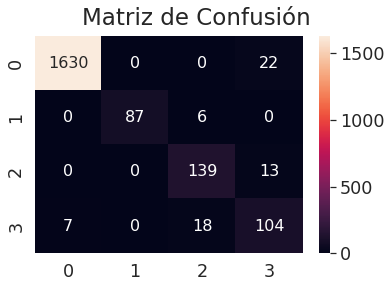

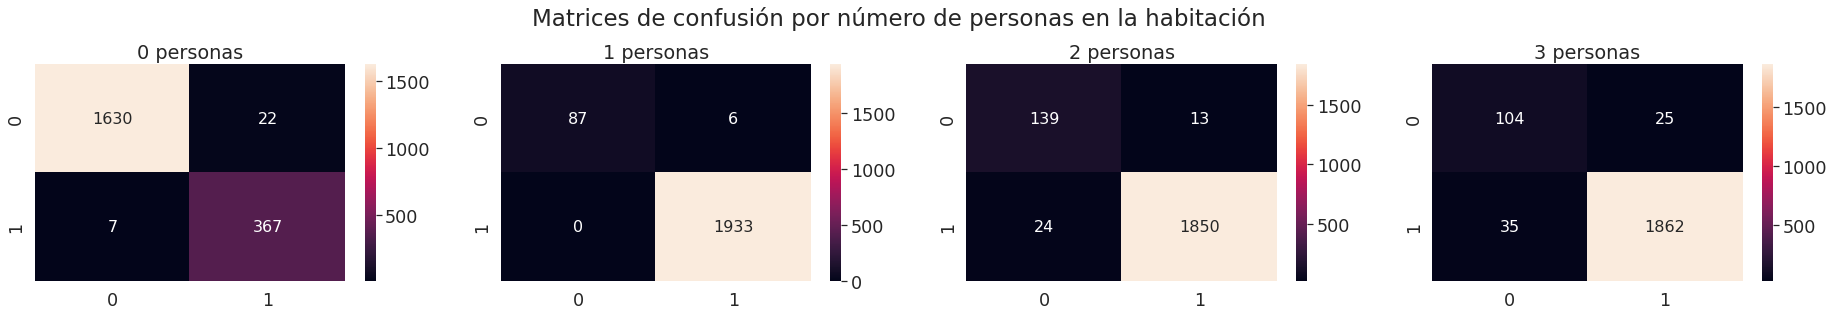

In [ ]:
#Analisis de resultados calsificador Bayesiano

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix)
plot_sub_confusion_matrixes(conf_matrix)

prob = clf.predict_proba(X_test)
data = {
    "probabilities": prob,
    "color": "red",
    "label": "Naive Bayes",
    "y_pred": y_pred
}
model_data.append(data)

In [ ]:
print_metrics(conf_matrix, "Naive Bayes")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Metricas para 0 personas (Naive Bayes)

Precision: 0.986682808716707
Recall: 0.9957238851557727
Accuracy: 0.9856860809476802
Specificity: 0.9434447300771208
F1 Score: 0.9911827303131652

*************************************

Metricas para 1 personas (Naive Bayes)

Precision: 0.9354838709677419
Recall: 1.0
Accuracy: 0.9970384995064165
Specificity: 0.9969056214543579
F1 Score: 0.9666666666666666

*************************************

Metricas para 2 personas (Naive Bayes)

Precision: 0.9144736842105263
Recall: 0.852760736196319
Accuracy: 0.9817374136229022
Specificity: 0.9930220075147611
F1 Score: 0.8825396825396825

*************************************

Metricas para 3 personas (Naive Bayes)

Precision: 0.8062015503875969
Recall: 0.7482014388489209
Accuracy: 0.9703849950641659
Specificity: 0.9867514573396926
F1 Score: 0.7761194029850746


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

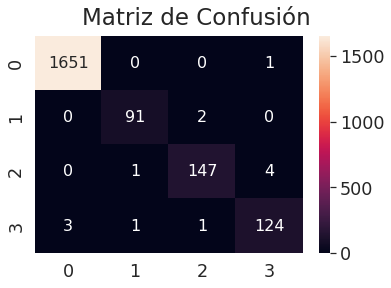

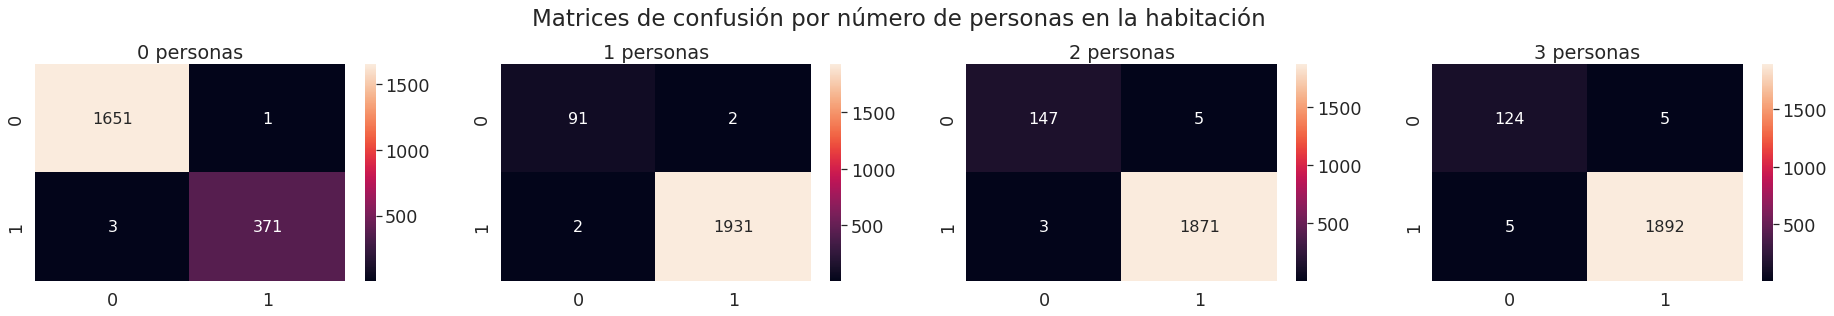

In [ ]:
#Entrenando Arbol de desición

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix)
plot_sub_confusion_matrixes(conf_matrix)

prob = clf.predict_proba(X_test)
data = {
    "probabilities": prob,
    "color": "blue",
    "label": "Árbol de Decisión",
    "y_pred": y_pred
}
model_data.append(data)

In [ ]:
print_metrics(conf_matrix, "Árbol de Decisión")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Metricas para 0 personas (Árbol de Decisión)

Precision: 1.0
Recall: 0.999395039322444
Accuracy: 0.9995064165844028
Specificity: 1.0
F1 Score: 0.999697428139183

*************************************

Metricas para 1 personas (Árbol de Decisión)

Precision: 0.978494623655914
Recall: 0.9891304347826086
Accuracy: 0.9985192497532083
Specificity: 0.9989658738366081
F1 Score: 0.9837837837837837

*************************************

Metricas para 2 personas (Árbol de Decisión)

Precision: 0.9671052631578947
Recall: 0.9735099337748344
Accuracy: 0.9955577492596249
Specificity: 0.9973333333333333
F1 Score: 0.9702970297029704

*************************************

Metricas para 3 personas (Árbol de Decisión)

Precision: 0.9767441860465116
Recall: 0.9692307692307692
Accuracy: 0.9965449160908193
Specificity: 0.9984177215189873
F1 Score: 0.9729729729729729


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

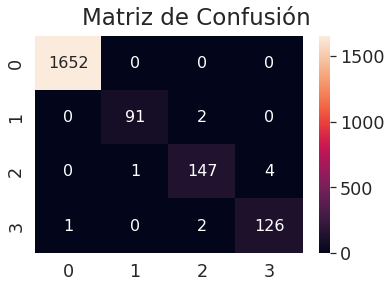

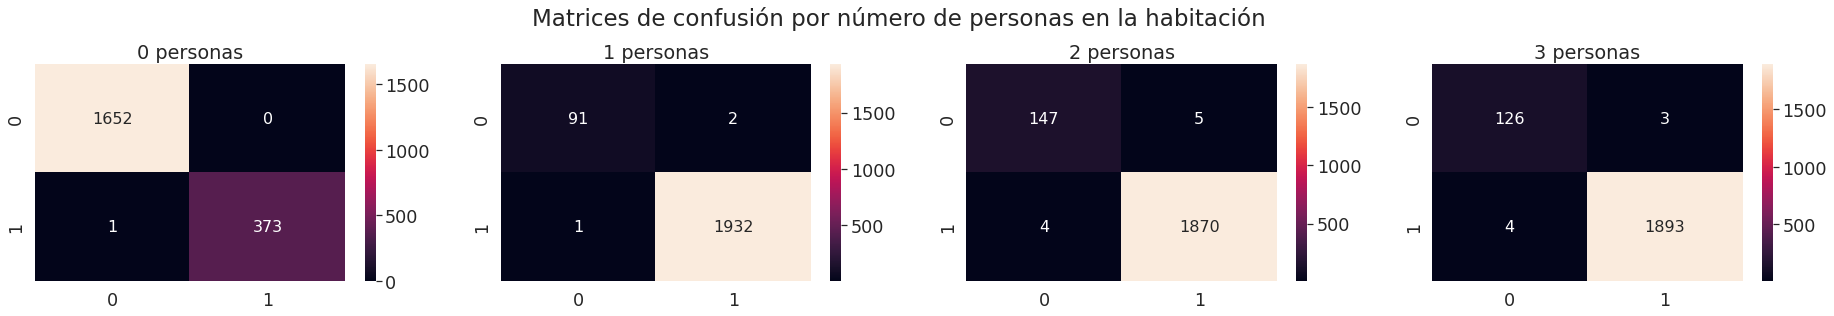

In [ ]:
#Analisis de resultados KNN

from sklearn.neighbors import KNeighborsClassifier

k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix)
plot_sub_confusion_matrixes(conf_matrix)

prob = clf.predict_proba(X_test)
data = {
    "probabilities": prob,
    "color": "green",
    "label": f"{k} Nearest Neighbors",
    "y_pred": y_pred
}
model_data.append(data)

In [ ]:
print_metrics(conf_matrix, f"{k} Nearest Neighbors")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Metricas para 0 personas (1 Nearest Neighbors)

Precision: 1.0
Recall: 0.999395039322444
Accuracy: 0.9995064165844028
Specificity: 1.0
F1 Score: 0.999697428139183

*************************************

Metricas para 1 personas (1 Nearest Neighbors)

Precision: 0.978494623655914
Recall: 0.9891304347826086
Accuracy: 0.9985192497532083
Specificity: 0.9989658738366081
F1 Score: 0.9837837837837837

*************************************

Metricas para 2 personas (1 Nearest Neighbors)

Precision: 0.9671052631578947
Recall: 0.9735099337748344
Accuracy: 0.9955577492596249
Specificity: 0.9973333333333333
F1 Score: 0.9702970297029704

*************************************

Metricas para 3 personas (1 Nearest Neighbors)

Precision: 0.9767441860465116
Recall: 0.9692307692307692
Accuracy: 0.9965449160908193
Specificity: 0.9984177215189873
F1 Score: 0.9729729729729729


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

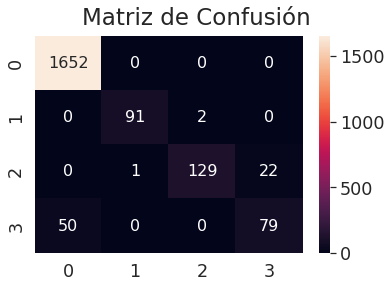

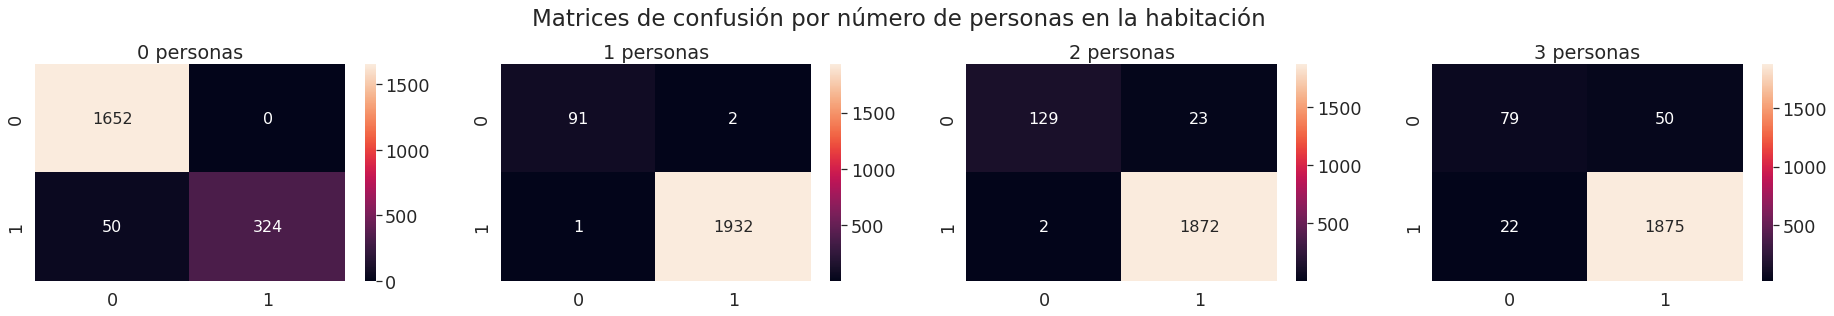

In [ ]:
#Analisis de resultados RadiusNeighbors

from sklearn.neighbors import RadiusNeighborsClassifier

clf = RadiusNeighborsClassifier(radius=50.0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(conf_matrix)
plot_sub_confusion_matrixes(conf_matrix)

prob = clf.predict_proba(X_test)
data = {
    "probabilities": prob,
    "color": "yellow",
    "label": "Radius Neighbours",
    "y_pred": y_pred
}
model_data.append(data)

In [ ]:
print_metrics(conf_matrix, "Radius Neighbours")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Metricas para 0 personas (Radius Neighbours)

Precision: 1.0
Recall: 0.9706227967097533
Accuracy: 0.9753208292201382
Specificity: 1.0
F1 Score: 0.985092426952892

*************************************

Metricas para 1 personas (Radius Neighbours)

Precision: 0.978494623655914
Recall: 0.9891304347826086
Accuracy: 0.9985192497532083
Specificity: 0.9989658738366081
F1 Score: 0.9837837837837837

*************************************

Metricas para 2 personas (Radius Neighbours)

Precision: 0.8486842105263158
Recall: 0.9847328244274809
Accuracy: 0.9876604146100691
Specificity: 0.9878627968337731
F1 Score: 0.911660777385159

*************************************

Metricas para 3 personas (Radius Neighbours)

Precision: 0.6124031007751938
Recall: 0.7821782178217822
Accuracy: 0.9644619940769991
Specificity: 0.974025974025974
F1 Score: 0.6869565217391305


##Conclusiones

Las métricas obtenidas nos permiten decir que nuestro modelo de ajusta de una manera optima a los datos de test. Por lo tanto este modelo es adecuado par la predicciones de cuantas personas hay en esta habitación en particular.

Pero para validar las métricas nos vamos a apoyar en una herramienta grafica la cual determinara la calidad del modelo. Y es la **Curva ROC**

En la siguiente sección se pueden ver las curvas ROC de cada clasificador para cada clase.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ROC AUC Naive Bayes (One vs Rest global): 0.9927
ROC AUC Árbol de Decisión (One vs Rest global): 0.9866
ROC AUC 1 Nearest Neighbors (One vs Rest global): 0.9894
ROC AUC Radius Neighbours (One vs Rest global): 0.9775
*******************************
ROC AUC Naive Bayes (One vs Rest weighted): 0.9973
ROC AUC Árbol de Decisión (One vs Rest weighted): 0.9934
ROC AUC 1 Nearest Neighbors (One vs Rest weighted): 0.9963
ROC AUC Radius Neighbours (One vs Rest weighted): 0.9814
*******************************
ROC AUC Naive Bayes (One vs One global): 0.9789
ROC AUC Árbol de Decisión (One vs One global): 0.9844
ROC AUC 1 Nearest Neighbors (One vs One global): 0.9871
ROC AUC Radius Neighbours (One vs One global): 0.9711
*******************************
ROC AUC Naive Bayes (One vs One weighted): 0.9924
ROC AUC Árbol de Decisión (One vs One weighted): 0.9886
ROC AUC 1 Nearest Neighbors (One vs One weighted): 0.9914
ROC AUC Radius Neighbours (One vs One weighted): 0.9781


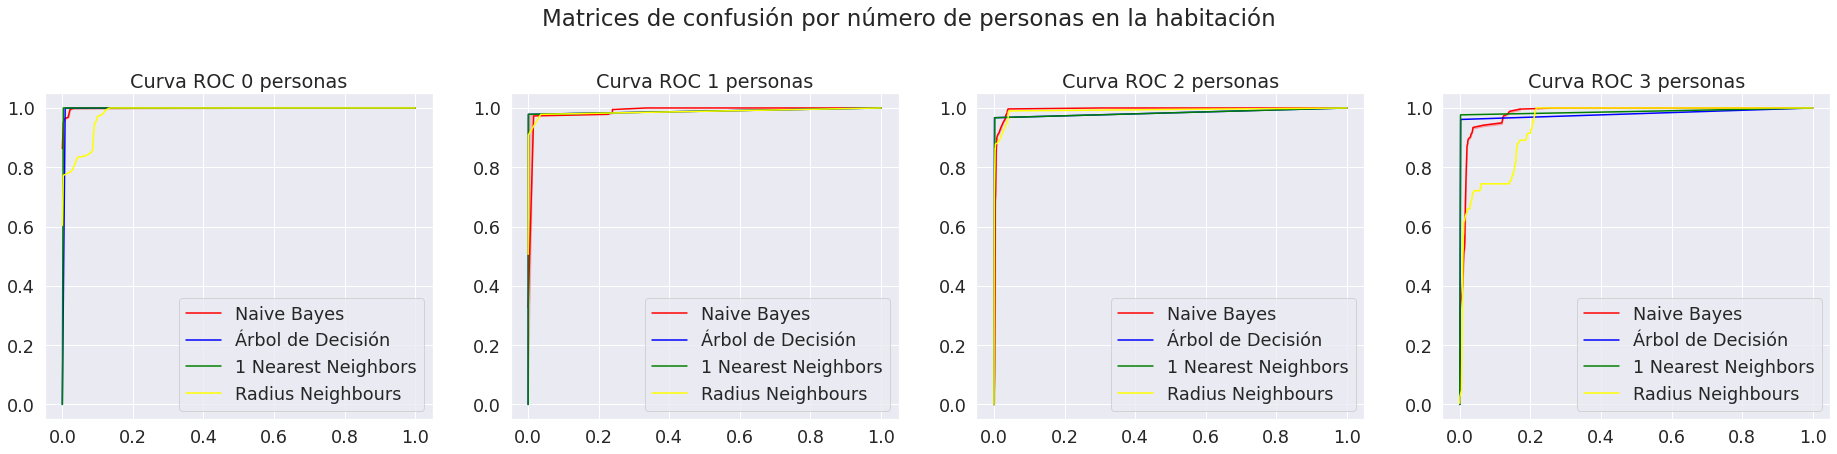

In [ ]:
def plot_roc_curve_per_class(model_data):
  fig, axes = plt.subplots(1, 4, sharex=True, figsize=(32,6))
  for i in range(4):
    for model in model_data:
      prob = model["probabilities"][:, i]
      fper, tper, _ = roc_curve(y_test, prob, pos_label=i)
      sns.set(font_scale=1.6)
      sns.lineplot(fper, tper, ax=axes[i], color=model["color"], label=model["label"])
    axes[i].set_title(f"Curva ROC {i} personas")
  fig.suptitle('Matrices de confusión por número de personas en la habitación', y=1.08)

def plot_roc_curve(model_data, clase):
    #plt.rcParams["figure.figsize"] = (16,16)
    for model in model_data:
      prob = model["probabilities"][:, clase]
      fper, tper, _ = roc_curve(y_test, prob[:,i], pos_label=1)
      plt.plot(fper, tper, color=model["color"], label=model["label"])
    plt.plot([0, 1], [0, 1], color='green', linestyle='--') #Baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

plot_roc_curve_per_class(model_data)

for model in model_data:
  score = roc_auc_score(y_test, model["probabilities"], multi_class='ovr', average="macro")
  label = model["label"]
  print(f"ROC AUC {label} (One vs Rest global): {score:.4f}")

print("*******************************")

for model in model_data:
  score = roc_auc_score(y_test, model["probabilities"], multi_class='ovr', average="weighted")
  label = model["label"]
  print(f"ROC AUC {label} (One vs Rest weighted): {score:.4f}")

print("*******************************")

for model in model_data:
  score = roc_auc_score(y_test, model["probabilities"], multi_class='ovo', average="macro")
  label = model["label"]
  print(f"ROC AUC {label} (One vs One global): {score:.4f}")

print("*******************************")

for model in model_data:
  score = roc_auc_score(y_test, model["probabilities"], multi_class='ovo', average="weighted")
  label = model["label"]
  print(f"ROC AUC {label} (One vs One weighted): {score:.4f}")

##Observación de la Curva ROC

Podemos visualizar en la Curva ROC que presenta un RATE del casi 0.99 lo cual indica que nuestro modelo se ajusta de manera optima a los datos usado para el testeo. Y es coincidente con los resultados de la métricas obtenidas anteriormente.

Las curvas ROC confirman nuevamente que los mejores clasificadores son KNN y Árbol de Decisión.

#Conclusiones Generales

Para la próxima entrega evaluamos la posibilidad de agregar a los atributos “Dates” y “Time” una vez que definamos como vamos a realizar su conversión de la manera más optima e implementar nuevos modelos. Para ver si esas características muestran un cambio en las métricas o sigue implementándose de la misma forma.

Con los resultados obtenidos podemos asegurar que no se produce **underfitting** y tampoco **Overfitting** dado que los datos de X_test e y_test no aparecen en los datos de entrenamiento. Pero eso lo podemos comprobar con la **Cross Validation** en la próxima entrega, una vez que agreguemos las dos variables categóricas q no tuvimos en cuenta.
